<a href="https://colab.research.google.com/github/Pedro-Boechat/trainee/blob/main/Periodo5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uma Rede Neural Convolucional (CNN) é uma classe de Rede Neural comumente aplicada para analisar imagens. Ela se baseia no uso de convoluções.

Uma convolução é a aplicação de um filtro a uma entrada que resulta em uma ativação. A aplicação repetida do mesmo filtro a uma entrada resulta em um mapa de ativações, o qual pode ser muito útil para identificar bordas, por exemplo.

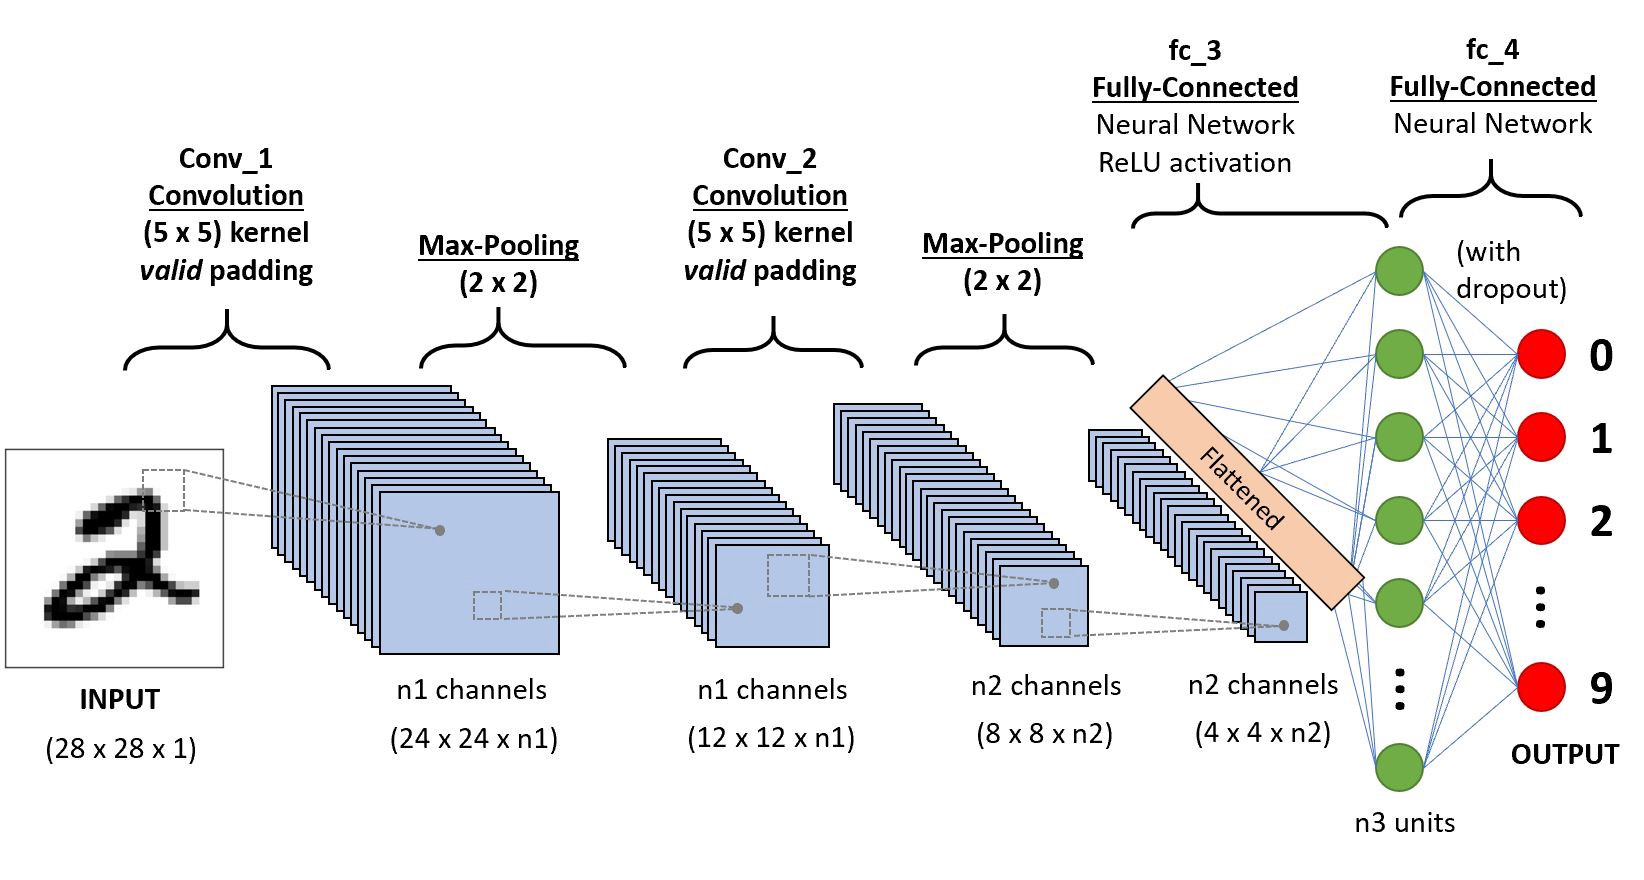

Para aumentar a eficiência de uma rede convolucional, pode-se utilizar algumas técnicas. Dentre as existentes, neste relatório foram usadas as técnicas de Dropout e Batch Normalization.

- Dropout: Para evitar overfitting e aumentar a velocidade de processamento da rede, a técnica de Dropout tem como objetivo aleatoriamente desabilitar unidades da rede neural durante o treinamento. Isso previne as unidades de se co-adaptarem demais. Como citado durante a reunião de meio período, uma possível analogia a esta técnica seria possibilitar que, quando um funcionário faltasse na empresa, o trabalho seria realizado da mesma forma.

- Batch Normalization é um método utilizado para fazer com que a rede neural seja mais rápida e mais estável por meio da normalização dos inputs das camadas.

Neste contexto, também foi utilizada a técnica de callback Early Stopping, que faz com que o modelo pare de treinar se não houver melhora por muitas épocas seguidas, o que indicaria um overfitting

Um conceito relevante para este relatório é o de Transfer Learning.

Trata-se de uma técnica em que uma rede neural já treinada para uma determinada finalidade é obtida, e o programador exclui as camadas de classificação a fim de adicionar suas próprias camadas, as quais seriam treinadas para o tópico abordado pela nova rede. Os pesos das primeiras camadas da rede não se alterariam, mantendo assim o aprendizado anterior que a rede teve, com o qual ela obteve alto desempenho.

Com este método, é possível utilizar redes previamente treinadas para classificação de flores, para o fim de classificar animais. Isto porque as primeiras camadas procuram features de baixo nível, as quais são similares para ambos os tópicos. Apenas as features de alto nível (das camadas finais) precisariam ser treinadas.

Isso reduz muito o tempo de treinamento da rede e aumenta a precisão, uma vez que as redes pré-treinadas foram passadas por milhões de amostras.

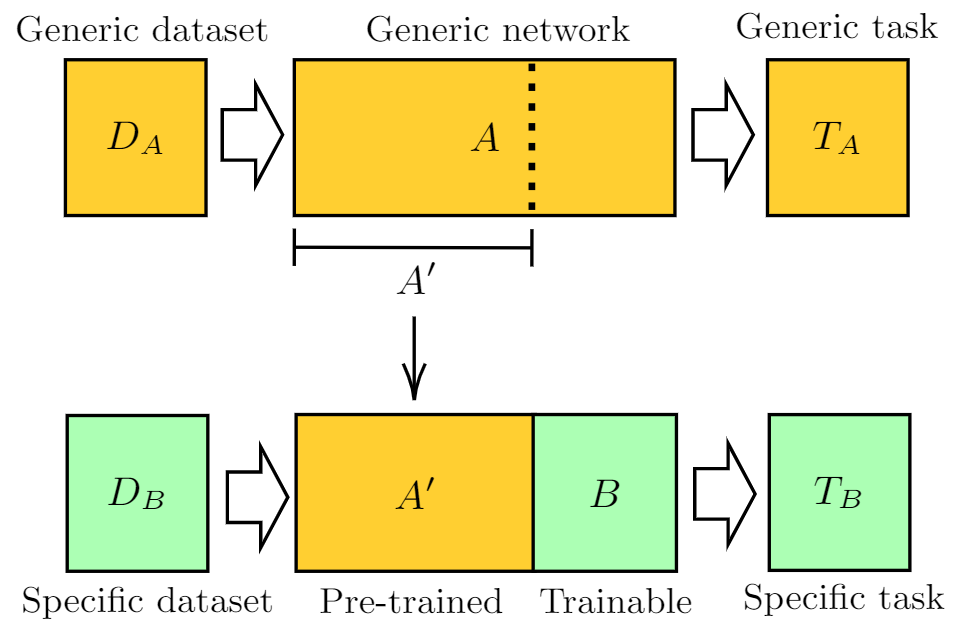

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import time
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import train_test_split
import random
import os
import cv2

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

dataset_path = '/content/gdrive/MyDrive/animals'


Mounted at /content/gdrive


Um comentário pertinente ao dataset é ressaltar que pandas são animais muito similares entre si, diferentemente dos cachorros e gatos, que variam em cor, tamanho e formato com grande frequência. Isso resulta em maior facilidade na classificação dos pandas em relação à dos cães e gatos deste dataset.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2
                                   )

In [ ]:
train_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(150, 150), color_mode='rgb', classes=['cats', 'dogs', 'panda'],
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='jpg',
    follow_links=False, subset='training', interpolation='nearest'
)

valid_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(150, 150), color_mode='rgb', classes=['cats', 'dogs', 'panda'],
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='jpg',
    follow_links=False, subset='validation', interpolation='nearest'
)

test_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(150,150), color_mode='rgb', classes=['cats', 'dogs', 'panda'],
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='jpg',
    follow_links=False, subset='validation', interpolation='nearest'
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


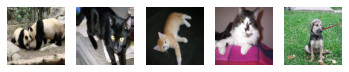

[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
imgs, labels = train_generator[1]

def plotImages(imgs):
  fig, axes = plt.subplots(1,5)
  axes = axes.flatten()
  for img, ax in zip(imgs, axes):
    ax.imshow(img)
    ax.axis('off')

  plt.show()

plotImages(imgs)
print(labels[:5])

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32,(5,5), activation = 'relu', input_shape = (150, 150, 3)),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(32,(5,5), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dropout(.5),
                             tf.keras.layers.Dense(32, activation = tf.nn.relu),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(.2)
])
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 32)        25632     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 36992)             0         
                                                                 
 dropout_5 (Dropout)         (None, 36992)            

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
    epochs = 15,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/15
75/75 [==============================] - 27s 365ms/step - loss: 0.6296 - accuracy: 0.7029 - val_loss: 1.1474 - val_accuracy: 0.5851
Epoch 2/15
75/75 [==============================] - 27s 360ms/step - loss: 0.6112 - accuracy: 0.7212 - val_loss: 0.7116 - val_accuracy: 0.6667
Epoch 3/15
75/75 [==============================] - 27s 362ms/step - loss: 0.5876 - accuracy: 0.7275 - val_loss: 0.6242 - val_accuracy: 0.6858
Epoch 4/15
75/75 [==============================] - 27s 361ms/step - loss: 0.5666 - accuracy: 0.7421 - val_loss: 0.6729 - val_accuracy: 0.6944
Epoch 5/15
75/75 [==============================] - 30s 396ms/step - loss: 0.5736 - accuracy: 0.7417 - val_loss: 0.7138 - val_accuracy: 0.6562
Epoch 6/15
75/75 [==============================] - 27s 357ms/step - loss: 0.5633 - accuracy: 0.7425 - val_loss: 0.8393 - val_accuracy: 0.6285
Epoch 7/15
75/75 [==============================] - 29s 383ms/step - loss: 0.5392 - accuracy: 0.7538 - val_loss: 0.6678 - val_accuracy: 0.6997

<function matplotlib.pyplot.show>

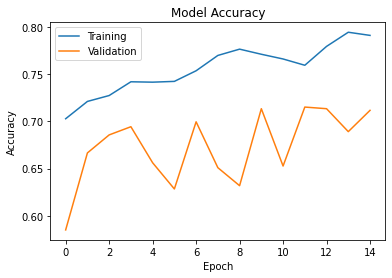

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show

O modelo em questão mostrou resultados significativamente melhores quando municiado de camadas Dropout e BatchNormalization, atingindo validation accuracy maior em menos épocas de treinamento.

In [ ]:
model.evaluate(test_generator)

19/19 [==============================] - 5s 281ms/step - loss: 0.6379 - accuracy: 0.7200


[0.6378901600837708, 0.7200000286102295]

Acurácia de teste em 72% condiz com a acurácia de validação do modelo

## VGG16

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import efficientnet
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization

In [ ]:
TM1 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in TM1.layers[:]:
    layer.trainable = False


In [ ]:
model = tf.keras.Sequential()
model.add(TM1)
model.add(Flatten())
model.add(Dropout(.5))
model.add(Dense(32, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(3, activation=tf.nn.softmax))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_8 (Dropout)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                      

Observa-se a presença de muitos parâmetros não treináveis. Trata-se dos parâmetros importados da rede pré-treinada VGG16

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(train_generator,
    epochs = 15,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/15
75/75 [==============================] - 33s 441ms/step - loss: 0.6507 - accuracy: 0.7367 - val_loss: 0.4516 - val_accuracy: 0.8333
Epoch 2/15
75/75 [==============================] - 29s 389ms/step - loss: 0.4556 - accuracy: 0.8179 - val_loss: 0.3812 - val_accuracy: 0.8438
Epoch 3/15
75/75 [==============================] - 30s 396ms/step - loss: 0.3984 - accuracy: 0.8454 - val_loss: 0.3851 - val_accuracy: 0.8368
Epoch 4/15
75/75 [==============================] - 30s 398ms/step - loss: 0.3647 - accuracy: 0.8579 - val_loss: 0.3583 - val_accuracy: 0.8628
Epoch 5/15
75/75 [==============================] - 29s 386ms/step - loss: 0.3417 - accuracy: 0.8662 - val_loss: 0.3185 - val_accuracy: 0.8819
Epoch 6/15
75/75 [==============================] - 29s 385ms/step - loss: 0.3358 - accuracy: 0.8667 - val_loss: 0.3248 - val_accuracy: 0.8819
Epoch 7/15
75/75 [==============================] - 29s 387ms/step - loss: 0.3238 - accuracy: 0.8804 - val_loss: 0.3230 - val_accuracy: 0.8750

In [ ]:
model.evaluate(test_generator)

19/19 [==============================] - 9s 440ms/step - loss: 0.3263 - accuracy: 0.8783


[0.3263445496559143, 0.878333330154419]

Utilizando transfer learning da rede VGG16, observa-se grande aumento de precisão do modelo em relação àquele não pré-treinado. O modelo otimizado obteve 88% de precisão

## Resnet50

In [ ]:
from tensorflow.keras.applications import resnet50


In [ ]:
TM1 = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in TM1.layers[:]:
    layer.trainable = False

In [ ]:
model = tf.keras.Sequential()
model.add(TM1)
model.add(Flatten())
model.add(Dropout(.5))
model.add(Dense(32, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(3, activation=tf.nn.softmax))

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_12 (Dropout)        (None, 51200)             0         
                                                                 
 dense_17 (Dense)            (None, 32)                1638432   
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                      

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
    epochs = 15,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/15
75/75 [==============================] - 34s 449ms/step - loss: 0.8451 - accuracy: 0.5800 - val_loss: 0.8497 - val_accuracy: 0.5833
Epoch 2/15
75/75 [==============================] - 31s 418ms/step - loss: 0.8681 - accuracy: 0.5750 - val_loss: 0.8308 - val_accuracy: 0.5972
Epoch 3/15
75/75 [==============================] - 29s 385ms/step - loss: 0.8425 - accuracy: 0.5842 - val_loss: 0.8442 - val_accuracy: 0.5920
Epoch 4/15
75/75 [==============================] - 29s 388ms/step - loss: 0.8369 - accuracy: 0.5933 - val_loss: 0.8305 - val_accuracy: 0.6042
Epoch 5/15
75/75 [==============================] - 32s 421ms/step - loss: 0.8322 - accuracy: 0.5971 - val_loss: 0.8375 - val_accuracy: 0.5851
Epoch 6/15
75/75 [==============================] - 29s 390ms/step - loss: 0.8500 - accuracy: 0.5875 - val_loss: 0.8291 - val_accuracy: 0.5903


<function matplotlib.pyplot.show>

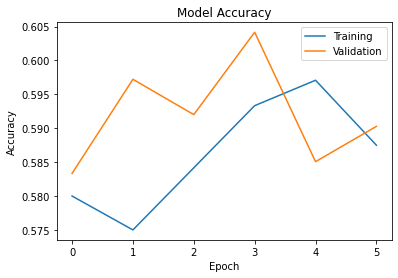

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show

É possível identificar overfitting na quarta época.

In [ ]:
model.evaluate(test_generator)

19/19 [==============================] - 6s 333ms/step - loss: 0.8281 - accuracy: 0.6033


[0.8281168341636658, 0.6033333539962769]

A rede neural que utiliza Transfer Learning da Resnet50 não obteve resultado tão bom.

# Conclusão

Houve resultados melhorados com o uso das técnicas Dropout e Batch Normalization para o modelo estudado. Sem o uso destas técnicas, a precisão do modelo variava entre 50 e 60 porcento. Com o uso delas, a precisão alcançou 71%.

Com o uso de tranfer learning, a rede VGG16 obteve resultados excepcionais. A rede Resnet50 obteve resultados razoáveis.